<a href="https://colab.research.google.com/github/VRehnberg/GraphRegularizedNNs/blob/main/mlp_coactivation_reg_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import neighbors, cluster
from sklearn.metrics import pairwise
from sklearn.manifold import SpectralEmbedding

from scipy.spatial.distance import pdist, squareform
!pip install pygsp
import pygsp
import torch
import numpy as np


def create_graph_from_layered_embedding(embs, frac:float = 0.1, n_clusters:int = 0):
    n_hidden = len(embs)
    layers = [e.shape[0] for e in embs]

    neighs = [neighbors.NearestNeighbors(n_neighbors=int(frac * layers[i] + 1), metric='cosine').fit(embs[i]) for i in range(n_hidden)]
    ids_per_layer = [sum(layers[:i]) + np.arange(layers[i], dtype=int) for i in range(n_hidden)]

    adj_mat = np.zeros((sum(layers), sum(layers)))

    for i in range(n_hidden):
        dist, ids = [x[:, 1:] for x in neighs[i].kneighbors(embs[i], return_distance=True)]
        for v1,v2s in enumerate(ids):
            adj_mat[ids_per_layer[i][v1], ids_per_layer[i][v2s]] = 1 - dist[v1,:]

        if i != n_hidden - 1:
            dist, ids = [x[:, :-1] for x in neighs[i + 1].kneighbors(embs[i], return_distance=True)]
            for v1,v2s in enumerate(ids):
                adj_mat[ids_per_layer[i][v1], ids_per_layer[i + 1][v2s]] = 1 - dist[v1,:]

        if i != 0:
            dist, ids = [x[:, :-1] for x in neighs[i - 1].kneighbors(embs[i], return_distance=True)]
            for v1,v2s in enumerate(ids):
                adj_mat[ids_per_layer[i][v1], ids_per_layer[i - 1][v2s]] = 1 - dist[v1,:]

    adj_mat = (adj_mat + adj_mat.T) / 2

    if n_clusters <= 0:
        return adj_mat

    clusts = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit(adj_mat).labels_

    mask = np.zeros_like(adj_mat)
    for i in range(clusts.max() + 1):
        mask[np.ix_(clusts == i, clusts == i)] = 1.0

    return (adj_mat > 1e-5) * mask

In [2]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

import gc
import collections
from functools import partial

import seaborn as sns

import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

%config Completer.use_jedi = False

dev = 'cuda:0'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [3]:
class Net(nn.Module):
    def __init__(self, layers, drop_p=0.2):
        super(Net,self).__init__()
        self.hidden = nn.ModuleList()
        for li,lo in zip(layers, layers[1:]):
            self.hidden.append(nn.Linear(li, lo))
        self.droput = nn.Dropout(drop_p)
        
    def forward(self,x):
        x = x.view(-1, INPUT_SHAPE)
        for i,l in enumerate(self.hidden):
            x = l(x)
            if i < len(self.hidden) - 1:
                x = self.droput(F.relu(x))
        return x

def eval_nn(nn, testloader):
    correct = 0
    loss_sublist = []
    for x,y in testloader:
        x,y = x.to(dev), y.to(dev)
        nn.eval()
        z = nn(x)
        _, yh = torch.max(z.data, 1)
        correct += (yh == y).sum().item()
        loss_sublist.append(crit(z, y).data.item())
    acc = correct / n_test
    return acc, round(np.mean(loss_sublist), 4)

def run_nn_train(nn, x, y, optimizer, crit):
    x,y = x.to(dev), y.to(dev)
    nn.train()
    optimizer.zero_grad()
    z = nn(x)
    return crit(z, y)

def clean_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainset_raw = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False, num_workers=2)

INPUT_SHAPE = 1 * 28 * 28
OUTPUT_SHAPE = 10

## Simple MLP

In [5]:
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
n_hidden = len(layers) - 2
ids_per_layer = [sum(layers[1:(i+1)]) + np.arange(layers[i+1], dtype=int) for i in range(n_hidden)]
mlp = Net(layers, drop_p=0.3).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
for name, m in mlp.named_modules():
    if type(m)==nn.Linear:
        m.register_forward_hook(partial(lambda name, mod, inp, out: activations[name].append(out.cpu()), name))

In [6]:
%%time

N_EPOCHS = 20
test_loss_list = []
accuracy_list = []
correct = 0
n_test = len(testset)
graph = None

for e in range(N_EPOCHS):
    activations = collections.defaultdict(list)
    # Train
    loss_sublist = []
    for x,y in trainloader:
        loss = run_nn_train(mlp, x, y, optimizer=optimizer, crit=crit)
        loss_sublist.append(loss.data.item())

        loss.backward()
        optimizer.step()

    # Test
    acc, test_loss = eval_nn(mlp, testloader)
    del x,y,loss
    clean_mem()

    test_loss_list.append(test_loss)
    print(f'{e}. Accuracy: {round(acc, 4)}, CE: {test_loss_list[-1]}')

0. Accuracy: 0.7096, CE: 0.8519
1. Accuracy: 0.769, CE: 0.6164
2. Accuracy: 0.7981, CE: 0.55
3. Accuracy: 0.8168, CE: 0.5062
4. Accuracy: 0.8253, CE: 0.4821
5. Accuracy: 0.834, CE: 0.462
6. Accuracy: 0.8383, CE: 0.4529
7. Accuracy: 0.8413, CE: 0.4428
8. Accuracy: 0.848, CE: 0.434
9. Accuracy: 0.8473, CE: 0.4328
10. Accuracy: 0.8476, CE: 0.4301
11. Accuracy: 0.8517, CE: 0.4216
12. Accuracy: 0.8498, CE: 0.4249
13. Accuracy: 0.8536, CE: 0.4166
14. Accuracy: 0.8587, CE: 0.4104
15. Accuracy: 0.8566, CE: 0.4144
16. Accuracy: 0.8574, CE: 0.4102
17. Accuracy: 0.8551, CE: 0.4139
18. Accuracy: 0.8565, CE: 0.4035
19. Accuracy: 0.8549, CE: 0.406
CPU times: user 10.3 s, sys: 4.53 s, total: 14.8 s
Wall time: 2min 36s


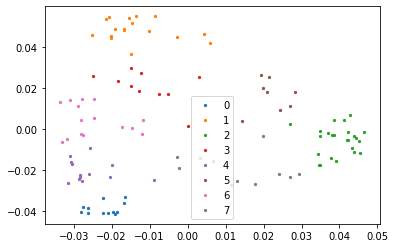

In [7]:
embs = [torch.vstack(activations[f'hidden.{i}']).T.detach().numpy() for i in range(n_hidden)]
adj_mat = create_graph_from_layered_embedding(embs, frac=0.3)

spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

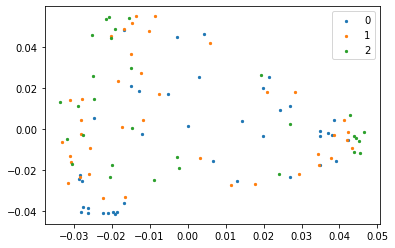

In [8]:
for i,ids in enumerate(ids_per_layer):
    plt.scatter(spec_emb[ids,0], spec_emb[ids,1], s=5, label=i)
plt.legend();

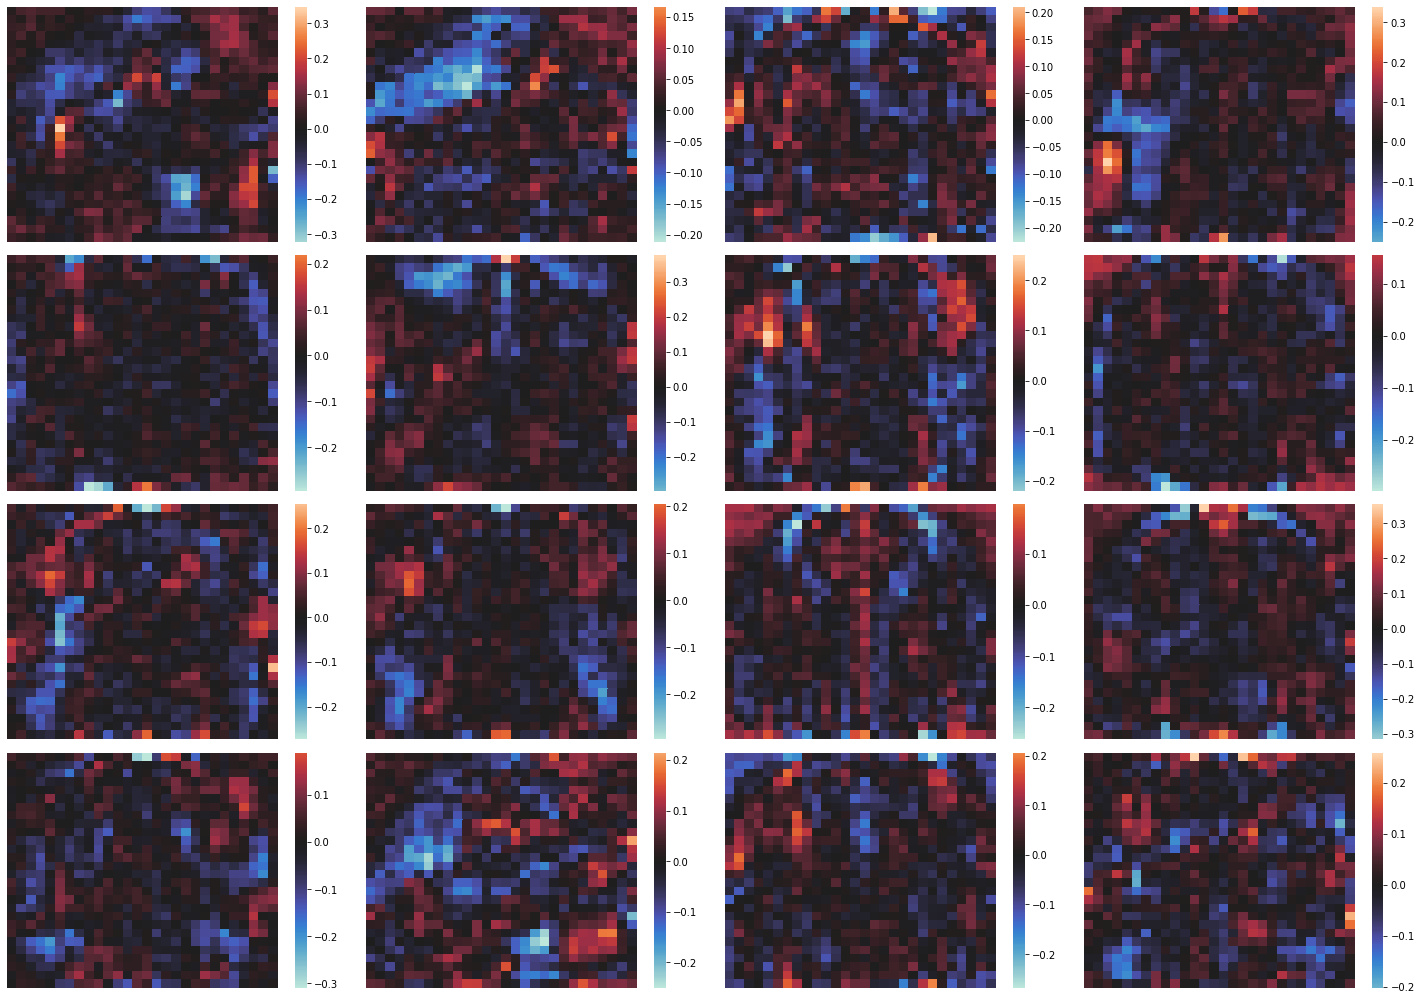

In [9]:
l1 = dict(mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 14))
for i in range(16):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[i])

plt.tight_layout()

## Graph MLP

In [10]:
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
n_hidden = len(layers) - 2
ids_per_layer = [sum(layers[1:(i+1)]) + np.arange(layers[i+1], dtype=int) for i in range(n_hidden)]

graph_mlp = Net(layers, drop_p=0.3).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(graph_mlp.parameters(), lr=0.001)
for name, m in graph_mlp.named_modules():
    if type(m)==nn.Linear:
        m.register_forward_hook(partial(lambda name, mod, inp, out: activations[name].append(out.cpu()), name))

In [11]:
%%time

N_EPOCHS = 20
test_loss_list = []
accuracy_list = []
correct = 0
n_test = len(testset)
lap = None

for e in range(N_EPOCHS):
    activations = collections.defaultdict(list)
    # Train
    loss_sublist = []
    gl_sublist = []
    for x,y in trainloader:
        loss = run_nn_train(graph_mlp, x, y, optimizer=optimizer, crit=crit)
        loss_sublist.append(loss.data.item())

        embs = [torch.vstack(activations[f'hidden.{i}']).T.detach().numpy() for i in range(n_hidden)]
        adj_mat = torch.from_numpy(create_graph_from_layered_embedding(embs, frac=0.3).astype(np.float32)).to(dev)

        degreessqrt = adj_mat.sum(0, keepdims=True).pow(-1./2.)
        adjnorm = adj_mat*degreessqrt*degreessqrt.T
        lap = torch.eye(adjnorm.shape[0]).to(dev) - adjnorm
        act = torch.hstack([activations[f'hidden.{li}'][-1] for li in range(n_hidden)]).to(dev)
        gl = (act.mm(lap) * act).sum() / act.shape[1] * 0.005
        gl_sublist.append(gl.detach().cpu().numpy())
        loss += gl

        loss.backward()
        optimizer.step()

    # Test
    acc, test_loss = eval_nn(graph_mlp, testloader)
    del x,y,loss
    clean_mem()
    print(f'{e}. Accuracy: {round(acc, 4)}, CE: {test_loss}, GL: {round(np.mean(gl_sublist), 3)}')

0. Accuracy: 0.3052, CE: 2.1989, GL: 0.13899999856948853
1. Accuracy: 0.424, CE: 1.5488, GL: 0.13500000536441803
2. Accuracy: 0.668, CE: 1.2484, GL: 0.1979999989271164
3. Accuracy: 0.689, CE: 1.0579, GL: 0.21199999749660492
4. Accuracy: 0.7118, CE: 0.974, GL: 0.20999999344348907
5. Accuracy: 0.7288, CE: 0.9081, GL: 0.19900000095367432
6. Accuracy: 0.729, CE: 0.8719, GL: 0.19599999487400055
7. Accuracy: 0.7333, CE: 0.8164, GL: 0.19499999284744263
8. Accuracy: 0.7533, CE: 0.7805, GL: 0.1940000057220459
9. Accuracy: 0.7583, CE: 0.765, GL: 0.19300000369548798
10. Accuracy: 0.7561, CE: 0.7306, GL: 0.19499999284744263
11. Accuracy: 0.7646, CE: 0.7151, GL: 0.19300000369548798
12. Accuracy: 0.7565, CE: 0.6958, GL: 0.1940000057220459
13. Accuracy: 0.7743, CE: 0.7011, GL: 0.18700000643730164
14. Accuracy: 0.76, CE: 0.6782, GL: 0.18700000643730164
15. Accuracy: 0.7675, CE: 0.6591, GL: 0.1850000023841858
16. Accuracy: 0.7714, CE: 0.6581, GL: 0.18199999630451202
17. Accuracy: 0.7697, CE: 0.6489, GL

In [12]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


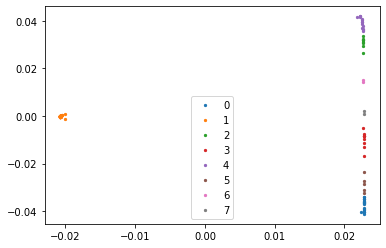

In [13]:
embs = [torch.vstack(activations[f'hidden.{i}']).T.detach().numpy() for i in range(n_hidden)]
adj_mat = create_graph_from_layered_embedding(embs, frac=0.3)

spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

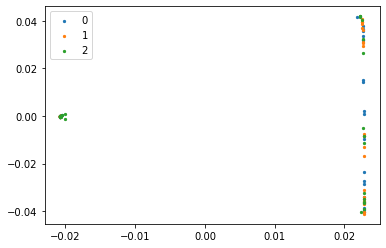

In [14]:
for i,ids in enumerate(ids_per_layer):
    plt.scatter(spec_emb[ids,0], spec_emb[ids,1], s=5, label=i)
plt.legend();

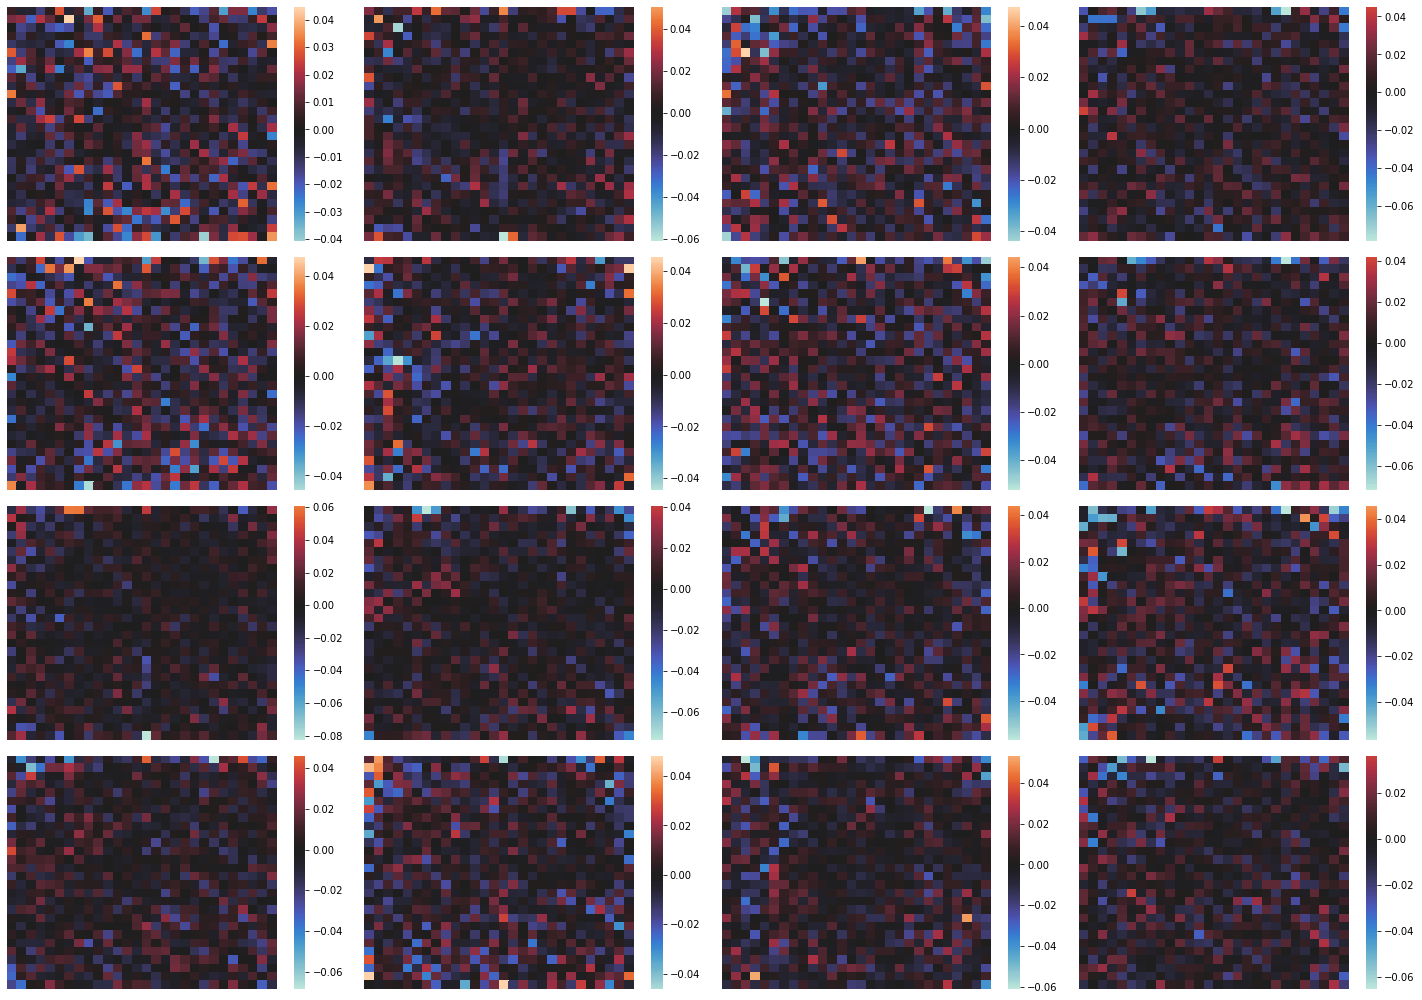

In [15]:
l1 = dict(graph_mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 14))
for i in range(16):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[i])

plt.tight_layout()